## The EDA

Answering to the question 

Do we have the RIGHT data to perform the prediction ?

For the purpose of EDA , following objective will be put into consideration.

- See if we have outliers and anomolies.
- See if data is skewed in particular range.

## Checking what is installed

In [2]:
%pip freeze

absl-py==2.2.1
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.14
aiohttp-cors==0.8.0
aiosignal==1.3.2
aiosqlite==0.21.0
annotated-types==0.7.0
ansicolors==1.1.8
anyio==4.9.0
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1737352602016/work
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
async-timeout==5.0.1
atpublic==5.1
attrs==25.3.0
babel==2.17.0
backoff==2.2.1
backports.tarfile==1.2.0
beautifulsoup4==4.13.3
bigframes==1.42.0
bleach==6.2.0
blessed==1.20.0
boltons @ file:///home/conda/feedstock_root/build_artifacts/boltons_1733827268945/work
bq_stats @ file:///tmp/environments/base/pip/packages/bq_stats
Brotli @ file:///home/conda/feedstock_root/build_artifacts/brotli-split_1725267488082/work
cachetools==5.5.2
certifi @ file:///home/conda/feedstock_root/build_artifacts/certifi_1739515848642/work/certifi
cffi @ file:///home/conda/feedstock_root/build_artifacts/cffi_1725560520483/work
charset-normalizer @ file:///home/conda/f

## Setup environment

### Setup package

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

### Additional packages

In [2]:
%pip install pytz

Note: you may need to restart the kernel to use updated packages.


## Running query in bigquery

### Raw query

In [3]:
%%bigquery
SELECT 
    COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,frac_delayed
0,0.186111


### As dataframe

In [4]:
sql = """
SELECT 
    COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""

from google.cloud import bigquery
bq = bigquery.Client()
df = bq.query(sql).to_dataframe()
print(df)

   frac_delayed
0      0.186111


## Basic statistics

In [5]:
%%bigquery df
SELECT arr_delay, dep_delay
FROM dsongcp.flights_tzcorr
WHERE DEP_DELAY >= 10

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df.describe()

,arr_delay,dep_delay
count,1286778.0,1294778.0
mean,46.117972,50.945163
std,63.606998,61.514225
min,-78.0,10.0
25%,11.0,17.0
50%,27.0,30.0
75%,59.0,61.0
max,1971.0,1988.0


(-50.0, 300.0)

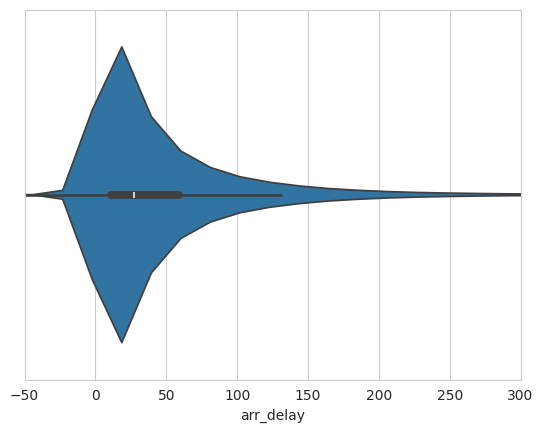

In [7]:
sb.set_style("whitegrid")
ax = sb.violinplot(data=df, x='arr_delay', inner='box', orient='h')
ax.axes.set_xlim(-50, 300)

## Comparing the results that are over 10 min and that are not

In [8]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr
WHERE CANCELLED IS NOT True AND DIVERTED IS NOT True

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
df.describe()

,ARR_DELAY,DEP_DELAY
count,5714008.0,5714008.0
mean,4.407057,9.294842
std,39.271297,36.889724
min,-87.0,-82.0
25%,-13.0,-5.0
50%,-5.0,-2.0
75%,8.0,7.0
max,1971.0,1988.0


In [10]:
df['ontime'] = df['DEP_DELAY'] < 10

(-50.0, 300.0)

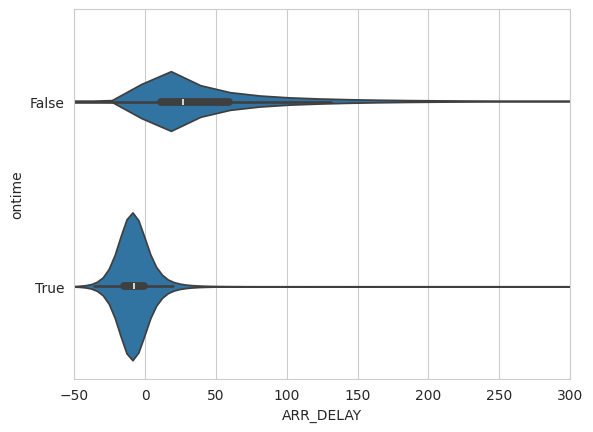

In [11]:
ax = sb.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 300)

Result shows that if departure delay is

less than 10

    the dataset is skewed toward around -5

greater than equal to 10

    the dataset is skewed toward high arrival delay
    
the unexpected distribution of data might affect the precision of prediction in the model I will will create.
Next I will check what is going on with the departure delay.

In [24]:
%%bigquery df
SELECT
  DEP_DELAY AS dep_delay,
  COUNT(ARR_DELAY) AS arrived_flights,
  AVG(ARR_DELAY) AS avg_arr_delay
FROM `dsongcp-452504.dsongcp.flights_tzcorr`
GROUP BY
  DEP_DELAY
HAVING DEP_DELAY > 10
ORDER BY
  DEP_DELAY ASC

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='dep_delay', ylabel='arrived_flights'>

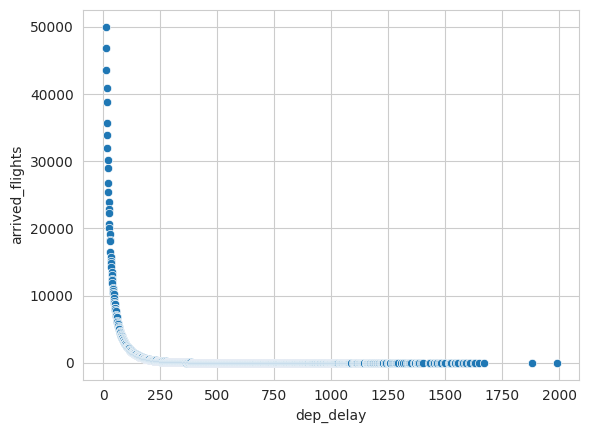

In [25]:
sb.scatterplot(data=df, x='dep_delay', y='arrived_flights')

In [27]:
df.head()

,dep_delay,arrived_flights,avg_arr_delay
0,11,50023,5.825880
1,12,46925,6.750155
2,13,43543,7.900168
3,14,40904,8.851628
4,15,38835,9.916210


## Removing oddball values

--Motivation comes here--

In [5]:
%%bigquery df
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) as arrival_delay,
    COUNT(ARR_DELAY) as numflights
FROM `dsongcp-452504.dsongcp.flights_tzcorr`
GROUP BY DEP_DELAY
ORDER BY arrival_delay ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df.head(10)

,DEP_DELAY,arrival_delay,numflights
0,<NA>,NaN,0
1,1274,NaN,0
2,1157,NaN,0
3,944,NaN,0
4,1079,NaN,0
5,879,NaN,0
6,-68,-87.0,1
7,-82,-80.0,1
8,-61,-77.0,1
9,-52,-61.0,1


In [10]:
df.sort_values(by='arrival_delay', ascending=False).head(10)

,DEP_DELAY,arrival_delay,numflights
1217,1988,1971.0,1
1216,1878,1898.0,1
1215,1670,1665.0,1
1214,1631,1638.0,1
1213,1625,1636.0,1
1212,1649,1636.0,1
1211,1587,1627.0,1
1210,1609,1598.0,1
1209,1604,1593.0,1
1208,1589,1576.0,1


Write insigts here

In [11]:
%%bigquery df
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) as arrival_delay,
    STDDEV(ARR_DELAY) as std_arrival_delay,
    COUNT(ARR_DELAY) as numflights
FROM `dsongcp-452504.dsongcp.flights_tzcorr`
GROUP BY DEP_DELAY
HAVING numflights > 370
ORDER BY arrival_delay ASC

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='DEP_DELAY'>

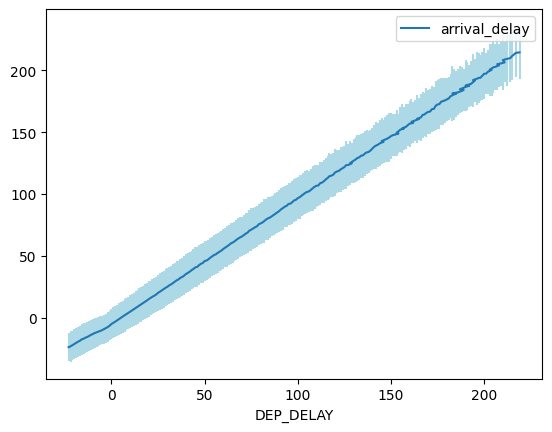

In [12]:
df.plot(
    kind='line',
    x='DEP_DELAY',
    y='arrival_delay',
    yerr='std_arrival_delay',
    ecolor='lightblue'
)